In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time

In [3]:
#!pip install boto3 awscli botocore

In [4]:
import boto3
import json

In [5]:
pd.set_option('display.float_format','{:.2f}'.format)

In [6]:
df = pd.read_excel("./news/weekly_news_amg_prices.xlsx", index_col='Date')

In [7]:
df

,Description,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog
Date,,,,,,,
2018-03-27,Alphabet Inc's Google is launching the Google...,78.62,74.85,94.94,83.75,53.15,50.26
2018-04-04,There are no specific U.S. policy changes at t...,67.91,70.53,87.85,86.43,49.67,51.26
2018-04-12,Janet Yellen cashed in with her first paid vis...,71.97,72.43,92.43,87.60,51.25,51.63
2018-04-22,Investors are optimistic that a pickup in corp...,78.06,76.37,95.91,88.93,54.10,53.65
2018-04-30,A gauge of global equity markets declined on M...,79.12,78.31,96.33,87.54,51.50,50.87
...,...,...,...,...,...,...,...
2020-06-14,With a full three months of responding to a gl...,130.06,127.25,190.54,181.58,71.42,70.66
2020-06-23,Stock market gains have further to run and inv...,136.30,138.22,202.09,195.28,72.78,73.22
2020-06-30,Alphabet Inc's Google said on Wednesday it wil...,134.25,137.94,197.88,196.83,69.52,70.68


In [8]:
# split data into seen data and unseen data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=False)

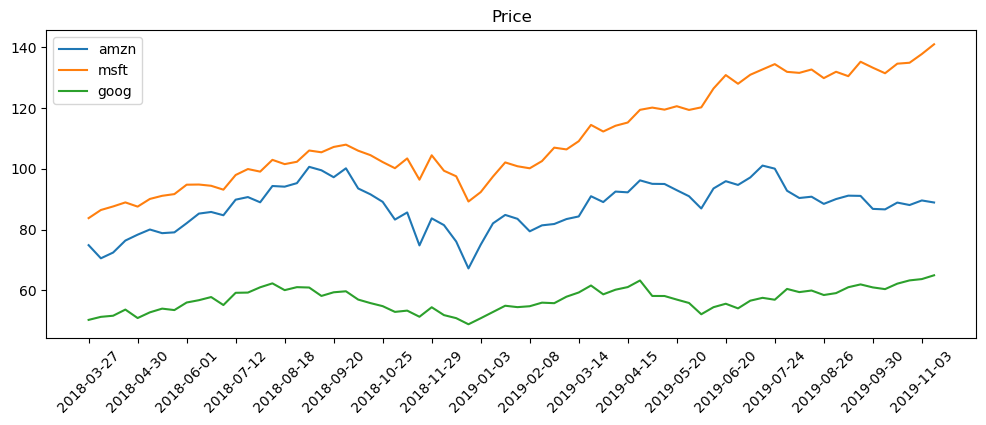

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(df_train.index, df_train['AdjClose_amzn'], label="amzn")
plt.plot(df_train.index, df_train['AdjClose_msft'], label="msft")
plt.plot(df_train.index, df_train['AdjClose_goog'], label="goog")
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_title("Price")
plt.legend()
plt.show()

In [10]:
amzn_gain = df_train['AdjClose_amzn'].iloc[-1]/df_train['AdjClose_amzn'].iloc[0]
msft_gain = df_train['AdjClose_msft'].iloc[-1]/df_train['AdjClose_msft'].iloc[0]
goog_gain = df_train['AdjClose_goog'].iloc[-1]/df_train['AdjClose_goog'].iloc[0]
avg_gain = (amzn_gain + msft_gain + goog_gain)/3

print(f"gains: amzn {amzn_gain}, msft {msft_gain}, goog {goog_gain} and avg {avg_gain}")

gains: amzn 1.1876690933813954, msft 1.6833114202603743, goog 1.2922097444590641 and avg 1.387730086033611


In [11]:

'''

Call Bedrock LLM

https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html

'''

'\n\nCall Bedrock LLM\n\nhttps://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html\n\n'

In [12]:


#Create the connection to Bedrock
bedrock = boto3.client(
    service_name='bedrock',
    region_name='us-west-2', 
    
)

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2', 
    
)

'''
# Let's see all available Anthropic Models
available_models = bedrock.list_foundation_models()

for model in available_models['modelSummaries']:
  if 'anthropic' in model['modelId']:
    print(model)
'''


"\n# Let's see all available Anthropic Models\navailable_models = bedrock.list_foundation_models()\n\nfor model in available_models['modelSummaries']:\n  if 'anthropic' in model['modelId']:\n    print(model)\n"

In [13]:
def generate_message(bedrock_runtime, model_id, system_prompt, messages, max_tokens):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": messages
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
   
    return response_body

In [14]:
'''
definition of antropic claude 3 haiku call
'''

'\ndefinition of antropic claude 3 haiku call\n'

In [15]:
# turning point
# improve the prompt for better statement assessment, consistent response

In [16]:
def anthropic_claude_3_haiku(statements):

    #print("statements:" + statements)
    
    model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
    system_prompt = "Always print '[Result]' before printing out the final points at step 7." \
        "Use only Amazon, Microsoft, Google, Market for company names at step 7." \
        "Print always all points even if it's 0 at step 7." \
        "Do not use parentheses before and after points at step 7."
    max_tokens = 5000

    content = statements \
        + "\nGiven the statements, follow these steps" \
        + " 1. categorize and present the statements into positive, negative, neutral to Amazon, Microsoft, Google stocks and entire stock market named Market." \
        + " 2. give 0 point for Amazon, Microsoft, Google and Market" \
        + " 3. add 1 point to the company points if a postive statement is specific to a company." \
        + " 4. subtract 1 point from the company points if a negative statement is specific to a company." \
        + " 5. add 1 points to Market if a positive statement is for entire stock market." \
        + " 6. subtract 1 points from Market if a negative statement is for entire stock market." \
        + " 7. print out the final points in company name:number format in Amazon, Microsoft, Google, Market order."
    

    user_message =  {"role": "user", "content": content}
    messages = [user_message]
    start = time.time()
    response = generate_message (bedrock_runtime, model_id, system_prompt, messages, max_tokens)
    end = time.time()

    content_text = response.get("content")[0]['text']

    if ( (end - start) > 10 ):
        print(f"\ninvocation time warning {(end - start)} secs")
    else:
        print('.', end='') # progress bar

    return content_text

In [17]:
# we're going to call the LLM for the entire data set rather than for train followed by test
# however, be careful not to future leak.

claude_responses = pd.DataFrame(data=df['Description']).copy(deep=True)
claude_responses['response'] = ""
claude_responses['result'] = ""

claude_responses['amzn'] = ""
claude_responses['msft'] = ""
claude_responses['goog'] = ""
claude_responses['market'] = ""


In [18]:
# call the model for responses
# or read it from saved responses

In [19]:
# this line reads the saved resposnes
claude_responses = pd.read_excel("./news/claude_responses_raw_weekly.xlsx", index_col='Date')

In [20]:
# this line is to reduce the number of LLM model calls to save time for tests
# leave only 3 days to call LLM
#claude_responses = claude_responses[:3]
#claude_responses

In [21]:
'''
call the llm for the rows in claude_responses
this may take some time e.g. 30 mins or more depending the number of rows 
'''
#claude_responses.loc[:, 'response'] = claude_responses['Description'].apply(anthropic_claude_3_haiku)


invocation time warning 14.684804201126099 secs
.
invocation time warning 13.95268177986145 secs

invocation time warning 18.26548957824707 secs

invocation time warning 15.608813285827637 secs
....
invocation time warning 12.329373598098755 secs
...
invocation time warning 18.34862756729126 secs

invocation time warning 12.255454301834106 secs

invocation time warning 10.787520170211792 secs
..
invocation time warning 10.6914541721344 secs
.
invocation time warning 10.801424980163574 secs

invocation time warning 18.758753776550293 secs

invocation time warning 18.617482900619507 secs

invocation time warning 15.841527223587036 secs
..
invocation time warning 16.492088794708252 secs
.....
invocation time warning 10.338829278945923 secs

invocation time warning 19.031112909317017 secs

invocation time warning 12.490741491317749 secs
.
invocation time warning 17.585132837295532 secs
.
invocation time warning 13.149056196212769 secs
..
invocation time warning 15.303379774093628 secs

in

In [22]:
'''
if you want, you can call the llm only one row
single call for a test i.e. description at 8th row
'''
#print(claude_responses.iloc[8]['Description'])
#print(anthropic_claude_3_haiku(claude_responses.iloc[8]['Description']))


'\nif you want, you can call the llm only one row\nsingle call for a test i.e. description at 8th row\n'

In [23]:
# check collected responses
claude_responses

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-03-27,Alphabet Inc's Google is launching the Google...,Here are the categorized statements and the fi...,,,,,
2018-04-04,There are no specific U.S. policy changes at t...,Here are the steps followed:\n\n1. Categorizin...,,,,,
2018-04-12,Janet Yellen cashed in with her first paid vis...,Positive Statements:\n- The U.S. dollar gained...,,,,,
2018-04-22,Investors are optimistic that a pickup in corp...,Categorizing the statements:\n\nPositive state...,,,,,
2018-04-30,A gauge of global equity markets declined on M...,[Positive Statements]\nPositive for Amazon:\n-...,,,,,
...,...,...,...,...,...,...,...
2020-06-14,With a full three months of responding to a gl...,Here are the steps:\n\n1. Categorizing the sta...,,,,,
2020-06-23,Stock market gains have further to run and inv...,[Result]\nPositive statements:\nAmazon: 1\nMic...,,,,,
2020-06-30,Alphabet Inc's Google said on Wednesday it wil...,Here are the steps:\n\n1. Categorization of st...,,,,,


In [24]:
# print out one as a sample i.e. 0th one
print(claude_responses.iloc[0]['response'])

Here are the categorized statements and the final points:

Positive Statements:
- Alphabet Inc's Google is launching the Google News Initiative, to weed out fake news online and during breaking news situations.
- A rise in oil prices to three-week highs helped lift equity markets worldwide on Tuesday.
- Stocks rose almost everywhere on Monday, reflecting optimism that the United States and China are set to begin negotiations on trade.

Negative Statements:
- Shares of Facebook, Twitter and Snapchat-owner Snap fell further on Tuesday as Wall Street fretted over potential regulatory scrutiny that could hobble the business of the social networks.
- Nordea, the Nordic region's biggest bank, will not let its sustainable funds buy more Facebook shares for the time being.
- U.S. stocks ended slightly lower on Wednesday, with major indexes giving up gains in choppy trade after the Federal Reserve raised U.S. interest rates.
- Major U.S. stock indexes fell as much as 2 percent on Thursday, wher

In [25]:
claude_responses.loc[:, 'result'] = claude_responses['response'].str.split(r"\[Result\]").str[1]

In [26]:

claude_responses.loc[:, 'amzn'] = claude_responses['result'].str.extract(r"Amazon\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'msft'] = claude_responses['result'].str.extract(r"Microsoft\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'goog'] = claude_responses['result'].str.extract(r"Google\: *([+|-]*[0-9]+)")[0]
claude_responses.loc[:, 'market'] = claude_responses['result'].str.extract(r"Market\: *([+|-]*[0-9]+)")[0]


In [27]:
claude_responses.to_excel("./news/claude_responses_raw_weekly.xlsx")

In [28]:
# how many responses were failed with parsing
claude_responses.isna().sum()

Description    0
response       0
result         5
amzn           7
msft           7
goog           7
market         7
dtype: int64

In [29]:
# see responses failed with parsing
claude_responses[claude_responses.isna().any(axis=1)]

,Description,response,result,amzn,msft,goog,market
Date,,,,,,,
2018-07-21,"The Federal Reserve on Friday pointed to ""soli...",[Result]\nPositive Statements:\nAmazon: The FA...,\nPositive Statements:\nAmazon: The FANGs have...,NaN,NaN,NaN,NaN
2018-08-26,As Wall Street prepares on Wednesday to celebr...,Here are the steps:\n\n1. Categorizing the sta...,NaN,NaN,NaN,NaN,NaN
2018-09-28,Alphabet Inc's Google gave details about its p...,Here are the steps:\n\n1. Categorizing the sta...,NaN,NaN,NaN,NaN,NaN
2018-10-17,As the Federal Reserve keeps raising interest ...,Here are the steps:\n\n1. Categorizing the sta...,NaN,NaN,NaN,NaN,NaN
2018-11-03,With 63 percent of MSCI's global index now in ...,Here are the steps:\n\n1. Categorizing the sta...,NaN,NaN,NaN,NaN,NaN
2019-04-08,"Saudi Aramco, the world's top oil producer, ha...",[Result]\nPositive Statements:\nMarket: Global...,\nPositive Statements:\nMarket: Global stocks ...,NaN,NaN,NaN,NaN
2020-01-20,"Seattle, the Pacific Northwest city where home...",Here are the steps:\n\n1. Categorizing the sta...,NaN,NaN,NaN,NaN,NaN


In [30]:
# let's ignore the failed with parsing as long as it's a small set; now set 0
claude_responses = claude_responses.fillna(0)
claude_responses['amzn'] = claude_responses['amzn'].astype(int)
claude_responses['msft'] = claude_responses['msft'].astype(int)
claude_responses['goog'] = claude_responses['goog'].astype(int)
claude_responses['market'] = claude_responses['market'].astype(int)

In [31]:
# split responses into train and test not to future leak.
#claude_responses_train, claude_responses_test = train_test_split(claude_responses, test_size=0.3, shuffle=False)

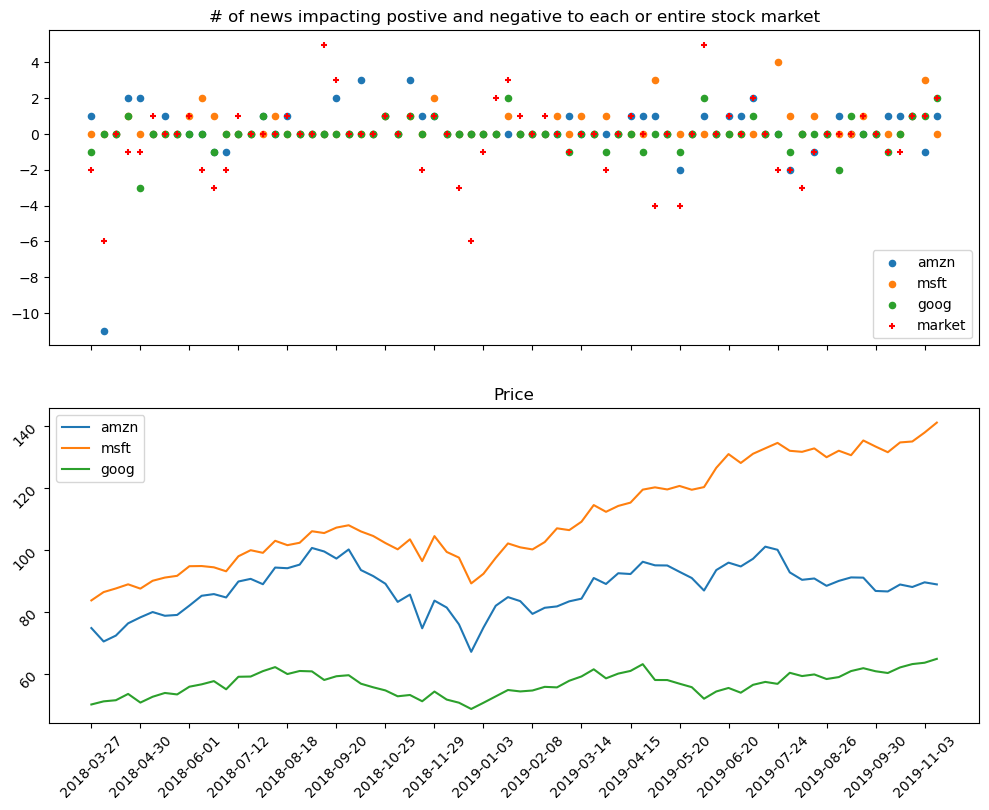

In [32]:
fig, axs = plt.subplots(2, figsize=(12,9), sharex=True)
axs[0].scatter(claude_responses_train.index, claude_responses_train['amzn'], label="amzn", s=20)
axs[0].scatter(claude_responses_train.index, claude_responses_train['msft'], label="msft", s=20)
axs[0].scatter(claude_responses_train.index, claude_responses_train['goog'], label="goog", s=20)
axs[0].scatter(claude_responses_train.index, claude_responses_train['market'], \
               label="market", s=20, color="red", marker='+')
# to make market news trend clearer
#axs[0].plot(claude_responses.index, claude_responses['market'], label="market", color="red")

axs[1].plot(df_train.index, df_train['AdjClose_amzn'], label="amzn")
axs[1].plot(df_train.index, df_train['AdjClose_msft'], label="msft")
axs[1].plot(df_train.index, df_train['AdjClose_goog'], label="goog")

axs[1].set_xticks(axs[1].get_xticks()[::4])
axs[1].tick_params(labelrotation=45)
axs[0].set_title("# of news impacting postive and negative to each or entire stock market")
axs[1].set_title("Price")
axs[0].legend()
axs[1].legend()

plt.show()

In [33]:
def evaluate_orders(orders):
    #initial cash
    initial_cash = 1000000
    
    book = \
    df[['Open_amzn', 'AdjClose_amzn', 'Open_msft', 'AdjClose_msft', 'Open_goog', 'AdjClose_goog']].copy(deep=True)
    
    book['o(a)'] = np.nan
    book['o(m)'] = np.nan
    book['o(g)'] = np.nan
    book['cash'] = 0.0
    book['u(a)'] = 0
    book['u(m)'] = 0
    book['u(g)'] = 0
    book['value'] = 0.0

    book.loc[book.index[0], 'cash'] = initial_cash
    book.loc[book.index[0], 'value'] = book.loc[book.index[0], 'cash'] \
        + book.loc[book.index[0], 'AdjClose_amzn'] * book.loc[book.index[0], 'u(a)'] \
        + book.loc[book.index[0], 'AdjClose_msft'] * book.loc[book.index[0], 'u(m)'] \
        + book.loc[book.index[0], 'AdjClose_goog'] * book.loc[book.index[0], 'u(g)']

    #insert orders
    book.loc[:, 'o(a)'] = orders['o(a)']
    book.loc[:, 'o(m)'] = orders['o(m)']
    book.loc[:, 'o(g)'] = orders['o(g)']

    #keep rasio for days without new orders
    book['o(a)'] = book['o(a)'].ffill()
    book['o(m)'] = book['o(m)'].ffill()
    book['o(g)'] = book['o(g)'].ffill()
    
    #calculate values
    order_date = book.index[0]
    #print(order_date)
    for date in book.index[1:]:
        #print(date)
        value = book.loc[order_date, 'cash']
        # for simple calculation, sell all at same price to buy then rebuy as order
        value += book.loc[order_date, 'u(a)'] * book.loc[date, 'Open_amzn']
        value += book.loc[order_date, 'u(m)'] * book.loc[date, 'Open_msft']
        value += book.loc[order_date, 'u(g)'] * book.loc[date, 'Open_goog']
        #print("value:" + str(value))
        cash = value
        # buy as order
        order = book.loc[order_date, 'o(a)']
        price = book.loc[date, 'Open_amzn']
        pay = value * order / 100
        book.loc[date, 'u(a)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"a o:{order} p:{price} pay:{pay} u(a): {book.loc[date, 'u(a)']} cash: {cash}")

        order = book.loc[order_date, 'o(m)']
        price = book.loc[date, 'Open_msft']
        pay = value * order / 100
        book.loc[date, 'u(m)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"m o:{order} p:{price} pay:{pay} u(m): {book.loc[date, 'u(m)']} cash: {cash}")

        order = book.loc[order_date, 'o(g)']
        price = book.loc[date, 'Open_goog']
        pay = value * order / 100
        book.loc[date, 'u(g)'] = pay // price
        cash = cash - pay + (pay % price)
        #print(f"g o:{order} p:{price} pay:{pay} u(g): {book.loc[date, 'u(g)']} cash: {cash}")

        book.loc[date, 'cash'] = cash
        book.loc[date, 'value'] = book.loc[date, 'cash'] \
            + book.loc[date, 'u(a)'] * book.loc[date, 'AdjClose_amzn'] \
            + book.loc[date, 'u(m)'] * book.loc[date, 'AdjClose_msft'] \
            + book.loc[date, 'u(g)'] * book.loc[date, 'AdjClose_goog']
        #print(f"cash {cash} value {book.loc[date, 'value']}")
        # set order date for the next day
        order_date = date
    
    return book

In [34]:
'''
base line 1: spend all money at first and see
'''

bl1_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])
bl1_order.loc[bl1_order.index[0], 'o(a)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(m)'] = 33.333333
bl1_order.loc[bl1_order.index[0], 'o(g)'] = 33.333333

In [35]:
bl1_book = evaluate_orders(bl1_order)
# manually calculate values
cash = bl1_book.iloc[1]['cash']
u_a = bl1_book.iloc[1]['u(a)']
u_m = bl1_book.iloc[1]['u(m)']
u_g = bl1_book.iloc[1]['u(g)']
for date in bl1_book.index[2:]:
    bl1_book.loc[date, 'o(a)'] = np.nan 
    bl1_book.loc[date, 'o(m)'] = np.nan 
    bl1_book.loc[date, 'o(g)'] = np.nan
    bl1_book.loc[date, 'cash'] = cash 
    bl1_book.loc[date, 'u(a)'] = u_a 
    bl1_book.loc[date, 'u(m)'] = u_m
    bl1_book.loc[date, 'u(g)'] = u_g
    bl1_book.loc[date, 'value'] = cash \
        + bl1_book.loc[date, 'AdjClose_amzn'] * bl1_book.loc[date, 'u(a)'] \
        + bl1_book.loc[date, 'AdjClose_msft'] * bl1_book.loc[date, 'u(m)'] \
        + bl1_book.loc[date, 'AdjClose_goog'] * bl1_book.loc[date, 'u(g)']

In [36]:
bl1_book.head(5)

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,33.33,33.33,33.33,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,33.33,33.33,33.33,95.93,4908,3794,6710,1018097.34
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,NaN,NaN,NaN,95.93,4908,3794,6710,1034317.40
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,NaN,NaN,NaN,95.93,4908,3794,6710,1072315.67
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,NaN,NaN,NaN,95.93,4908,3794,6710,1057877.79


In [37]:
'''
base line 2 always evenly distribute among 3
'''
bl2_order = pd.DataFrame(data=np.nan, index=df.index, columns=['o(a)', 'o(m)', 'o(g)'])

bl2_order.loc[bl2_order.index[0], 'o(a)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(m)'] = 30.0
bl2_order.loc[bl2_order.index[0], 'o(g)'] = 30.0

In [38]:
bl2_book = evaluate_orders(bl2_order)

In [39]:
bl2_book.head(5)

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,30.00,30.00,30.00,100152.63,4417,3414,6039,1016287.94
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,30.00,30.00,30.00,104488.72,4347,3385,6105,1031018.14
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,30.00,30.00,30.00,110058.11,4222,3436,6092,1064893.99
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,30.00,30.00,30.00,108955.58,4128,3391,6342,1051659.55


In [40]:
'''

my order

'''

'\n\nmy order\n\n'

In [41]:
claude_responses_train[['amzn', 'msft', 'goog', 'market']].describe()

,amzn,msft,goog,market
count,70.00,70.00,70.00,70.00
mean,0.20,0.40,0.03,-0.20
std,1.63,0.81,0.78,1.93
min,-11.00,0.00,-3.00,-6.00
25%,0.00,0.00,0.00,-1.00
50%,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.00,1.00
max,3.00,4.00,2.00,5.00


In [42]:
[std_a, std_m, std_g, std_mk] = claude_responses_train[['amzn', 'msft', 'goog', 'market']].std()

In [43]:
orders = pd.DataFrame(data=claude_responses[['amzn', 'msft', 'goog', 'market']]).copy(deep=True)
orders['o(a)'] = 0.0
orders['o(m)'] = 0.0
orders['o(g)'] = 0.0

In [44]:
# turning point
# set ratio among AMG with a strategy from company news and market news

In [45]:
orders.loc[orders.index[0], 'o(a)'] = 30.0
orders.loc[orders.index[0], 'o(m)'] = 30.0
orders.loc[orders.index[0], 'o(g)'] = 30.0

In [73]:
# company factor
cf = 5
# market factor
mf = 0.1


yesterday = orders.index[0]
for date in orders.index[1:]:
    
    # from yesterday's news, dicide today's ratio or %
    # must be always > 0
    o_a = max(orders.loc[yesterday,'o(a)']+orders.loc[yesterday,'amzn']*cf+orders.loc[yesterday,'market']*mf, 0)
    o_m = max(orders.loc[yesterday,'o(m)']+orders.loc[yesterday,'msft']*cf+orders.loc[yesterday,'market']*mf, 0)
    o_g = max(orders.loc[yesterday,'o(g)']+orders.loc[yesterday,'goog']*cf+orders.loc[yesterday,'market']*mf, 0)
        
    # must be always > 0
    o_a = max(o_a, 0)
    o_m = max(o_m, 0)
    o_g = max(o_g, 0)
    
    #scale if sum > 100
    o_sum = o_a + o_m + o_g
    if ( o_sum > 100 ):
        o_a = o_a * 100 / o_sum
        o_m = o_m * 100 / o_sum
        o_g = o_g * 100 / o_sum
    
    orders.loc[date,'o(a)'] = o_a
    orders.loc[date,'o(m)'] = o_m
    orders.loc[date,'o(g)'] = o_g
    
    # for next look
    yesterday = date


In [74]:
orders

,amzn,msft,goog,market,o(a),o(m),o(g)
Date,,,,,,,
2018-03-27,1,0,-1,-2,30.00,30.00,30.00
2018-04-04,-11,0,0,-6,34.80,29.80,24.80
2018-04-12,0,0,0,0,0.00,29.20,24.20
2018-04-22,2,1,1,-1,0.00,29.20,24.20
2018-04-30,2,0,-3,-1,9.90,34.10,29.10
...,...,...,...,...,...,...,...
2020-06-14,0,0,0,0,55.45,44.16,0.38
2020-06-23,1,1,1,1,55.45,44.16,0.38
2020-06-30,1,0,0,0,52.52,42.73,4.76


In [75]:
# split responses into train and test not to future leak.
orders_train, orders_test = train_test_split(orders, test_size=0.3, shuffle=False)

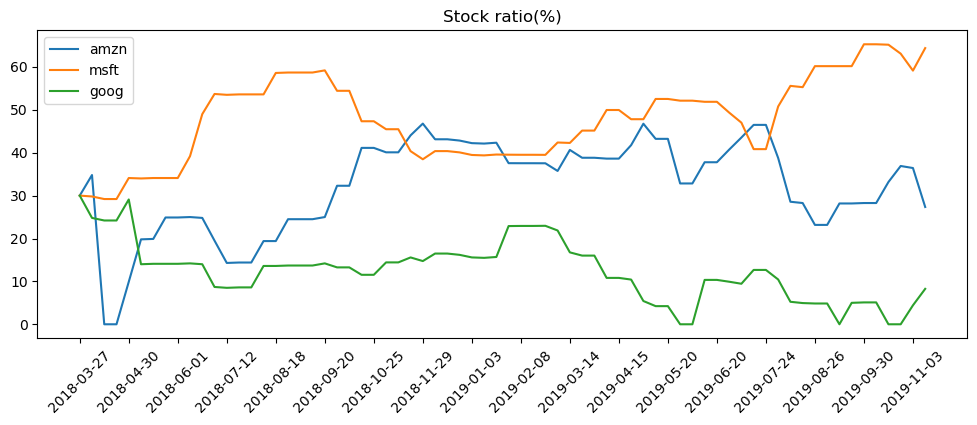

In [102]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(orders_train.index, orders_train['o(a)'], label="amzn")
plt.plot(orders_train.index, orders_train['o(m)'], label="msft")
plt.plot(orders_train.index, orders_train['o(g)'], label="goog")
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_title("Stock ratio(%)")
plt.legend()
plt.show()

In [77]:
my_order = orders
my_book = evaluate_orders(my_order)

In [78]:
my_book

,Open_amzn,AdjClose_amzn,Open_msft,AdjClose_msft,Open_goog,AdjClose_goog,o(a),o(m),o(g),cash,u(a),u(m),u(g),value
Date,,,,,,,,,,,,,,
2018-03-27,78.62,74.85,94.94,83.75,53.15,50.26,30.00,30.00,30.00,1000000.00,0,0,0,1000000.00
2018-04-04,67.91,70.53,87.85,86.43,49.67,51.26,34.80,29.80,24.80,100152.63,4417,3414,6039,1016287.94
2018-04-12,71.97,72.43,92.43,87.60,51.25,51.63,0.00,29.20,24.20,110652.19,5043,3363,5047,1031042.46
2018-04-22,78.06,76.37,95.91,88.93,54.10,53.65,0.00,29.20,24.20,512618.11,0,3348,4920,1074299.69
2018-04-30,79.12,78.31,96.33,87.54,51.50,50.87,9.90,34.10,29.10,507347.19,0,3299,5114,1056283.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14,130.06,127.25,190.54,181.58,71.42,70.66,55.45,44.16,0.38,130292.96,6991,4592,0,1853706.19
2020-06-23,136.30,138.22,202.09,195.28,72.78,73.22,55.45,44.16,0.38,128.09,8182,4395,105,1996999.99
2020-06-30,134.25,137.94,197.88,196.83,69.52,70.68,52.52,42.73,4.76,102.78,8160,4409,108,2001155.30


In [79]:
bl1_gain = bl1_book['value'].iloc[-1]/bl1_book['value'].iloc[0]
bl2_gain = bl2_book['value'].iloc[-1]/bl2_book['value'].iloc[0]
your_gain = my_book['value'].iloc[-1]/my_book['value'].iloc[0]
print(f"your gain: {your_gain}")
print(f"base line1 gain: {bl1_gain} your gain/bl1 ratio: {your_gain/bl1_gain}")
print(f"base line2 gain: {bl2_gain} your gain/bl2 ratio {your_gain/bl2_gain}")

your gain: 2.087970724272999
base line1 gain: 1.979888910038 your gain/bl1 ratio: 1.0545898376858551
base line2 gain: 1.869972633553999 your gain/bl2 ratio 1.116578225160804


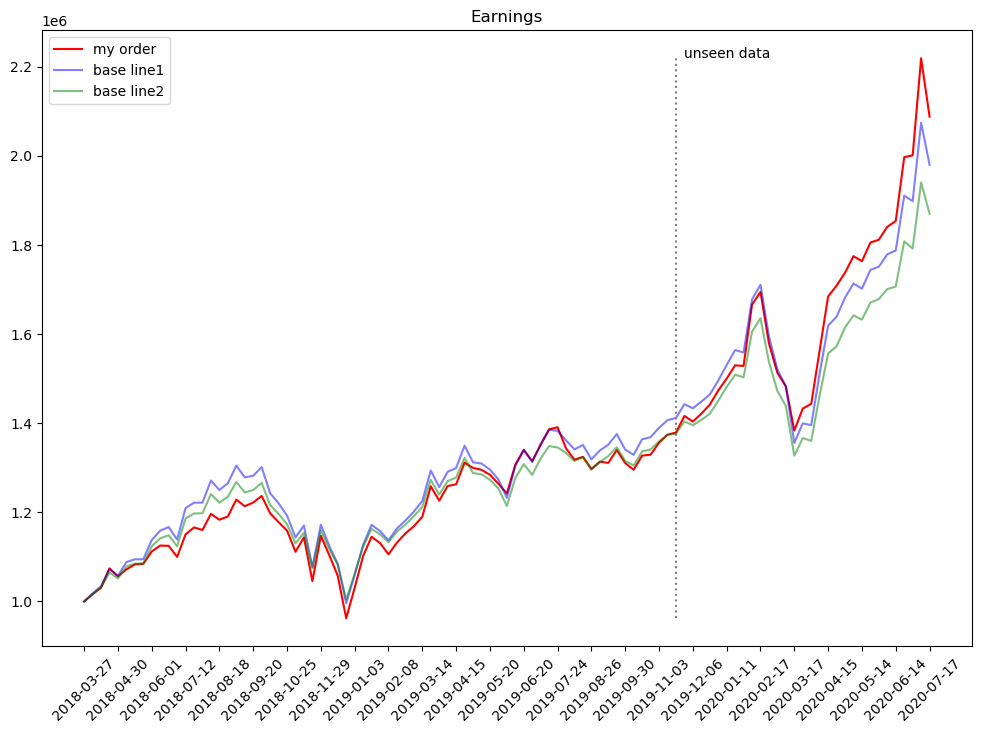

In [103]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(my_book.index, my_book['value'], label = "my order", color='red', alpha=1.0)
plt.plot(bl1_book.index, bl1_book['value'], label = "base line1", color='blue', alpha=0.5)
plt.plot(bl2_book.index, bl2_book['value'], label = "base line2", color='green', alpha=0.5)
plt.xticks(rotation = 45)
ax.set_xticks(ax.get_xticks()[::4])
plt.vlines(x=orders_test.index[0], ymin=my_book['value'].min(), ymax=my_book['value'].max(), \
           linestyles='dotted', color='grey')
plt.text(orders_test.index[1], my_book['value'].max(), "unseen data")
ax.set_title("Earnings")
plt.legend() 
plt.show()

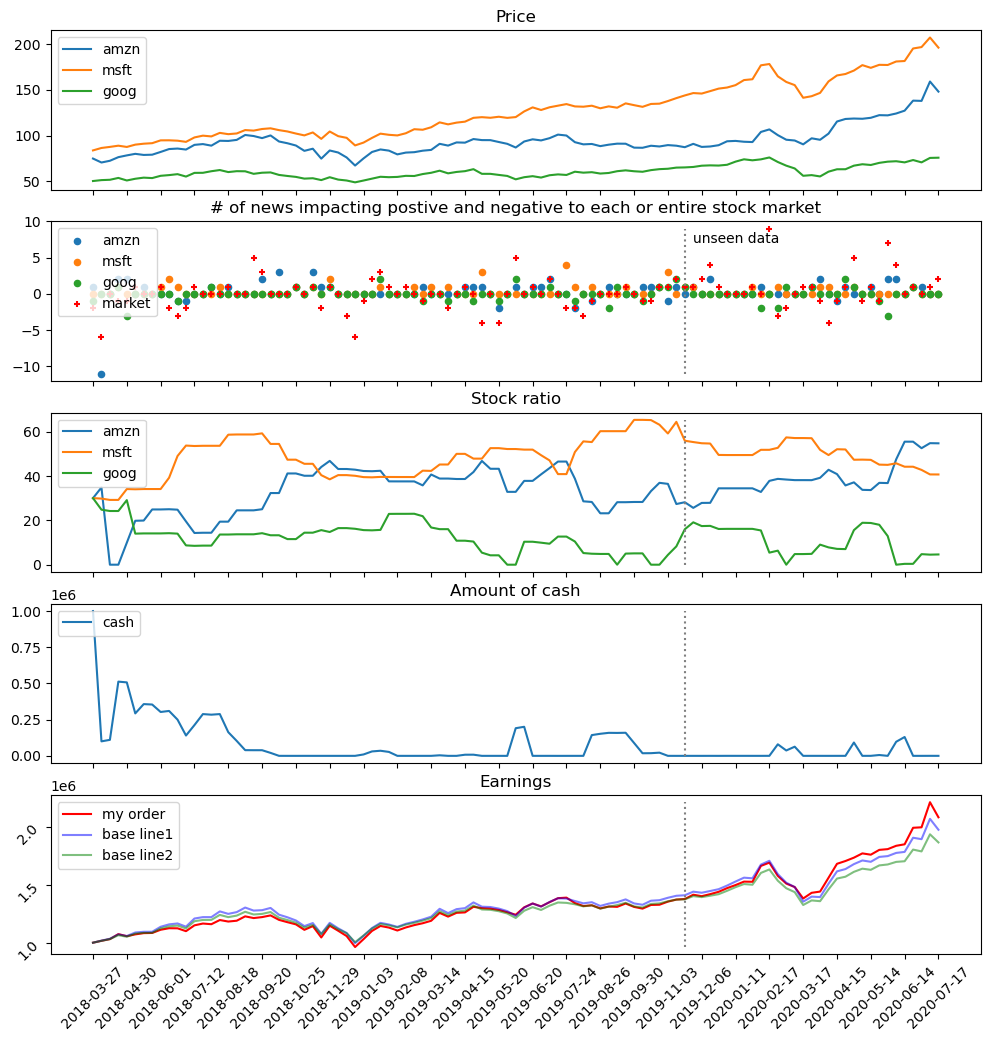

In [123]:
fig, axs = plt.subplots(5, figsize=(12,12), sharex=True)

axs[0].plot(df.index, df['AdjClose_amzn'], label="amzn")
axs[0].plot(df.index, df['AdjClose_msft'], label="msft")
axs[0].plot(df.index, df['AdjClose_goog'], label="goog")

axs[1].scatter(claude_responses.index, claude_responses['amzn'], label="amzn", s=20)
axs[1].scatter(claude_responses.index, claude_responses['msft'], label="msft", s=20)
axs[1].scatter(claude_responses.index, claude_responses['goog'], label="goog", s=20)
axs[1].scatter(claude_responses.index, claude_responses['market'], label="market", s=20, color="red", marker='+')
axs[1].vlines(x=claude_responses_test.index[0], \
              ymin=claude_responses['amzn'].min(), ymax=claude_responses['market'].max(), \
              linestyles='dotted', color='grey')
axs[1].text(claude_responses_test.index[1], claude_responses['market'].max()-2, "unseen data")
# to make market news trend clearer
#axs[1].plot(claude_responses.index, claude_responses['market'], label="market", color="red")

axs[2].plot(my_order.index, my_order['o(a)'], label="amzn")
axs[2].plot(my_order.index, my_order['o(m)'], label="msft")
axs[2].plot(my_order.index, my_order['o(g)'], label="goog")
axs[2].vlines(x=orders_test.index[0], \
              ymin=my_order[['o(a)', 'o(m)', 'o(g)']].min().min(), 
              ymax=my_order[['o(a)', 'o(m)', 'o(g)']].max().max(), \
              linestyles='dotted', color='grey')

axs[3].plot(my_book.index, my_book['cash'], label="cash")
axs[3].vlines(x=orders_test.index[0], \
              ymin=my_book['cash'].min(), ymax=my_book['cash'].max(), \
              linestyles='dotted', color='grey')

axs[4].plot(my_book.index, my_book['value'], label = "my order", color='red', alpha=1.0)
axs[4].plot(bl1_book.index, bl1_book['value'], label = "base line1", color='blue', alpha=0.5)
axs[4].plot(bl2_book.index, bl2_book['value'], label = "base line2", color='green', alpha=0.5)
axs[4].vlines(x=orders_test.index[0], ymin=my_book['value'].min(), ymax=my_book['value'].max(), \
           linestyles='dotted', color='grey')

axs[4].set_xticks(axs[3].get_xticks()[::4])
axs[4].tick_params(labelrotation=45)
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')
axs[3].legend(loc='upper left')
axs[4].legend(loc='upper left')
axs[0].set_title("Price")
axs[1].set_title("# of news impacting postive and negative to each or entire stock market")
axs[2].set_title("Stock ratio")
axs[3].set_title("Amount of cash")
axs[4].set_title("Earnings")

plt.show()